## Imports

In [122]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import Angle
from astropy import units
from scipy.interpolate import RectBivariateSpline
from scipy import interpolate
import copy
import os
import sys
from tqdm.notebook import tqdm
#from tqdm import tqdm
import glob
import h5py
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = "18"

PATH="/home/ghoshsonia/rfi_RRI/PRATUSH-PRATUSH_sensitivity/sky_models/"

#path_ms1 = '/home/pratush/Documents/saras3/'
#path_ms2 = '/home/pratush/Documents/saras3/utils'
#sys.path.append(path_ms1)
#sys.path.append(path_ms2)

#from ms_fit_joint import *
import scipy.io

## Define paths and constants

In [172]:
CHANNEL_WIDTH       = 0.06103515625/2.0 #/* MHz */
NUMBER_OF_CHANNELS  = 8193
START_FREQUENCY     = 0.00 #/* MHz */

PCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
PNUMBER_OF_CHANNELS = 41
PSTART_FREQUENCY    = 210.44921875 #/* MHz */

RCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
RNUMBER_OF_CHANNELS = 103
RSTART_FREQUENCY    = 109.86328125 #/* MHz */

QCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
QNUMBER_OF_CHANNELS = 72
QSTART_FREQUENCY    = 39.5507812500 #/* MHz */

SITE_LATITUDE       =  32.81302       #51.1657       #-25.2744    #32.81302 #/* +32.77944444   deg for Hanle */ 
SITE_LONGITUDE      =   78.87130     # 10.4515       #133.7751 #    78.87130 #/* 78.96416667 deg for Hanle */

NHPIX               = 3072
PI                  = 3.14159265358979

TCMB                = 2.72548

filename_coord      = "PIXEL_LISTING_NESTED_R4_GALACTIC.txt" #GMOSS

filename_pix_spec1  ="total_model_spec_13jan17_3072pix_103fq.txt"
filename_pix_spec2  ="total_model_spec_24jan17_1_3072_freq_40_110_MHz_16spacing.txt"
filename_pix_spec3  ="total_model_spec_31jan17_210_250_16spacing.txt"

beam_path  = '/home/ghoshsonia/rfi_RRI/PRATUSH_mayuri/beam_files/elec_small_ant_with_2_12U_bus_cone_scale_0_925_ref_scale_0_9999'
rt_file    = 'gamma_linear.txt'
file_list  = sorted(glob.glob(os.path.join(beam_path,"*mhz.txt")))


##### Fitting constants

fmin = 56.0/1e3
fmax = 109.0/1e3

domain = 'log_log'
LOWF   = fmin*1e3
HGHF   = fmax*1e3
order  = 10

## Define some utility functions

In [184]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for val, line in enumerate(data):
            if val==0:
                continue
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))
    return x, y

def Read_pixel_freq(file_name, nfreq):
    with open(file_name, 'r') as data:
        x = np.zeros((NHPIX, nfreq))
        for val, line in enumerate(data):
            if val==0:
                continue
            x[val-1] = [float(i) for i in line.split()]
    return x, np.shape(x)[1]

def select_freq_1d(x1, low, high): 
    prl = 0 
    prh = 0 
    for i in range(0, len(x1)):
        if x1[i]<=low:
            i_low=i+1
            prl = 1 
        if x1[i]>=high:
            i_high=i
            prh = 1 
            break
    if prl==1 and prh==0:
        i_high = len(x1)-1
    if prl==0 and prh==1:
        i_low = 1    
    return i_low, i_high

beam_monopole = lambda theta, phi: np.sin(np.radians(theta))**2 #Maxima at zenith #horizon
#beam_monopole_sidelobe = lambda theta, phi: 0.025*np.cos(np.radians(theta))**2


## Read Return Loss

In [125]:
gamme_file = os.path.join(beam_path, rt_file)

gamma_freq = []
gamma_val  = []

with open(gamme_file) as fa:
    for line_aa in fa.readlines()[3:]:
        line_aa = line_aa.strip()
        col1    = line_aa.split('\t')
        _freq   = np.array(list(map(float, col1[0].split())))[0]
        _val    = np.array(list(map(float, col1[1].split())))[0]
        gamma_freq.append(_freq)
        gamma_val.append(_val)
        
gamma_freq = np.array(gamma_freq)
gamma_val  = np.array(gamma_val)
    
gamma_func = scipy.interpolate.interp1d(gamma_freq, gamma_val)

## Read, process, and visualize beam files

In [126]:
phi_res   = 1
theta_res = 1

phi_array   = np.arange(0, 360, phi_res)
theta_array = np.arange(-90, 90 + theta_res, theta_res) #because arange does not accept endpoint. Stupid.
freq_array  = []
file_array  = []

def get_freq_from_file(filename):
    _temp = os.path.basename(filename).replace('.txt','').replace('mhz','')
    return float(_temp)
    
for ii, file_add in enumerate(file_list):
    freq_array.append(get_freq_from_file(file_add))
    file_array.append(file_add)
    
np.testing.assert_array_equal(file_array, file_list)

In [127]:
freq_array = np.array(freq_array)
file_array = np.array(file_array)

isort      = np.argsort(freq_array)
freq_array = freq_array[isort]
file_array = file_array[isort]

beam_3D_unnorm = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

for ii, freq in enumerate(freq_array):
    print("Processing frequency {:.1f} MHz".format(freq))
    file_add = file_array[ii]
    with open(file_add) as fa:
        for line_aa in fa.readlines()[2:]:
            line_aa = line_aa.strip()
            col1    = line_aa.split('\t')
            all_val = np.array(list(map(float, col1[0].split())))

            theta   = all_val[0] - 90
            phi     = all_val[1]
            beam    = all_val[2]
            
            iphi    = np.where(phi_array==phi)[0][0]
            itheta  = np.where(theta_array==theta)[0][0]
            beam_3D_unnorm[ii, itheta, iphi] = beam

Processing frequency 55.0 MHz
Processing frequency 57.5 MHz
Processing frequency 60.0 MHz
Processing frequency 62.5 MHz
Processing frequency 65.0 MHz
Processing frequency 67.5 MHz
Processing frequency 70.0 MHz
Processing frequency 72.5 MHz
Processing frequency 75.0 MHz
Processing frequency 77.5 MHz
Processing frequency 80.0 MHz
Processing frequency 82.5 MHz
Processing frequency 85.0 MHz
Processing frequency 87.5 MHz
Processing frequency 90.0 MHz
Processing frequency 92.5 MHz
Processing frequency 95.0 MHz
Processing frequency 97.5 MHz
Processing frequency 100.0 MHz
Processing frequency 102.5 MHz
Processing frequency 105.0 MHz
Processing frequency 107.5 MHz
Processing frequency 110.0 MHz


In [128]:
beam_3D = np.zeros((len(freq_array), len(theta_array), len(phi_array)))
for ifreq in range(beam_3D.shape[0]):
    for iphi in range(beam_3D.shape[2]):
        beam_3D[ifreq,:,iphi] = beam_3D_unnorm[ifreq, :, iphi]/np.amax(beam_3D_unnorm[ifreq, :, iphi])

In [129]:
theta_array_new = theta_array
phi_array_new   = phi_array

In [130]:
from scipy.interpolate import RegularGridInterpolator
my_interpolating_function = RegularGridInterpolator((\
                                                     freq_array, theta_array_new, \
                                                     phi_array_new), beam_3D)

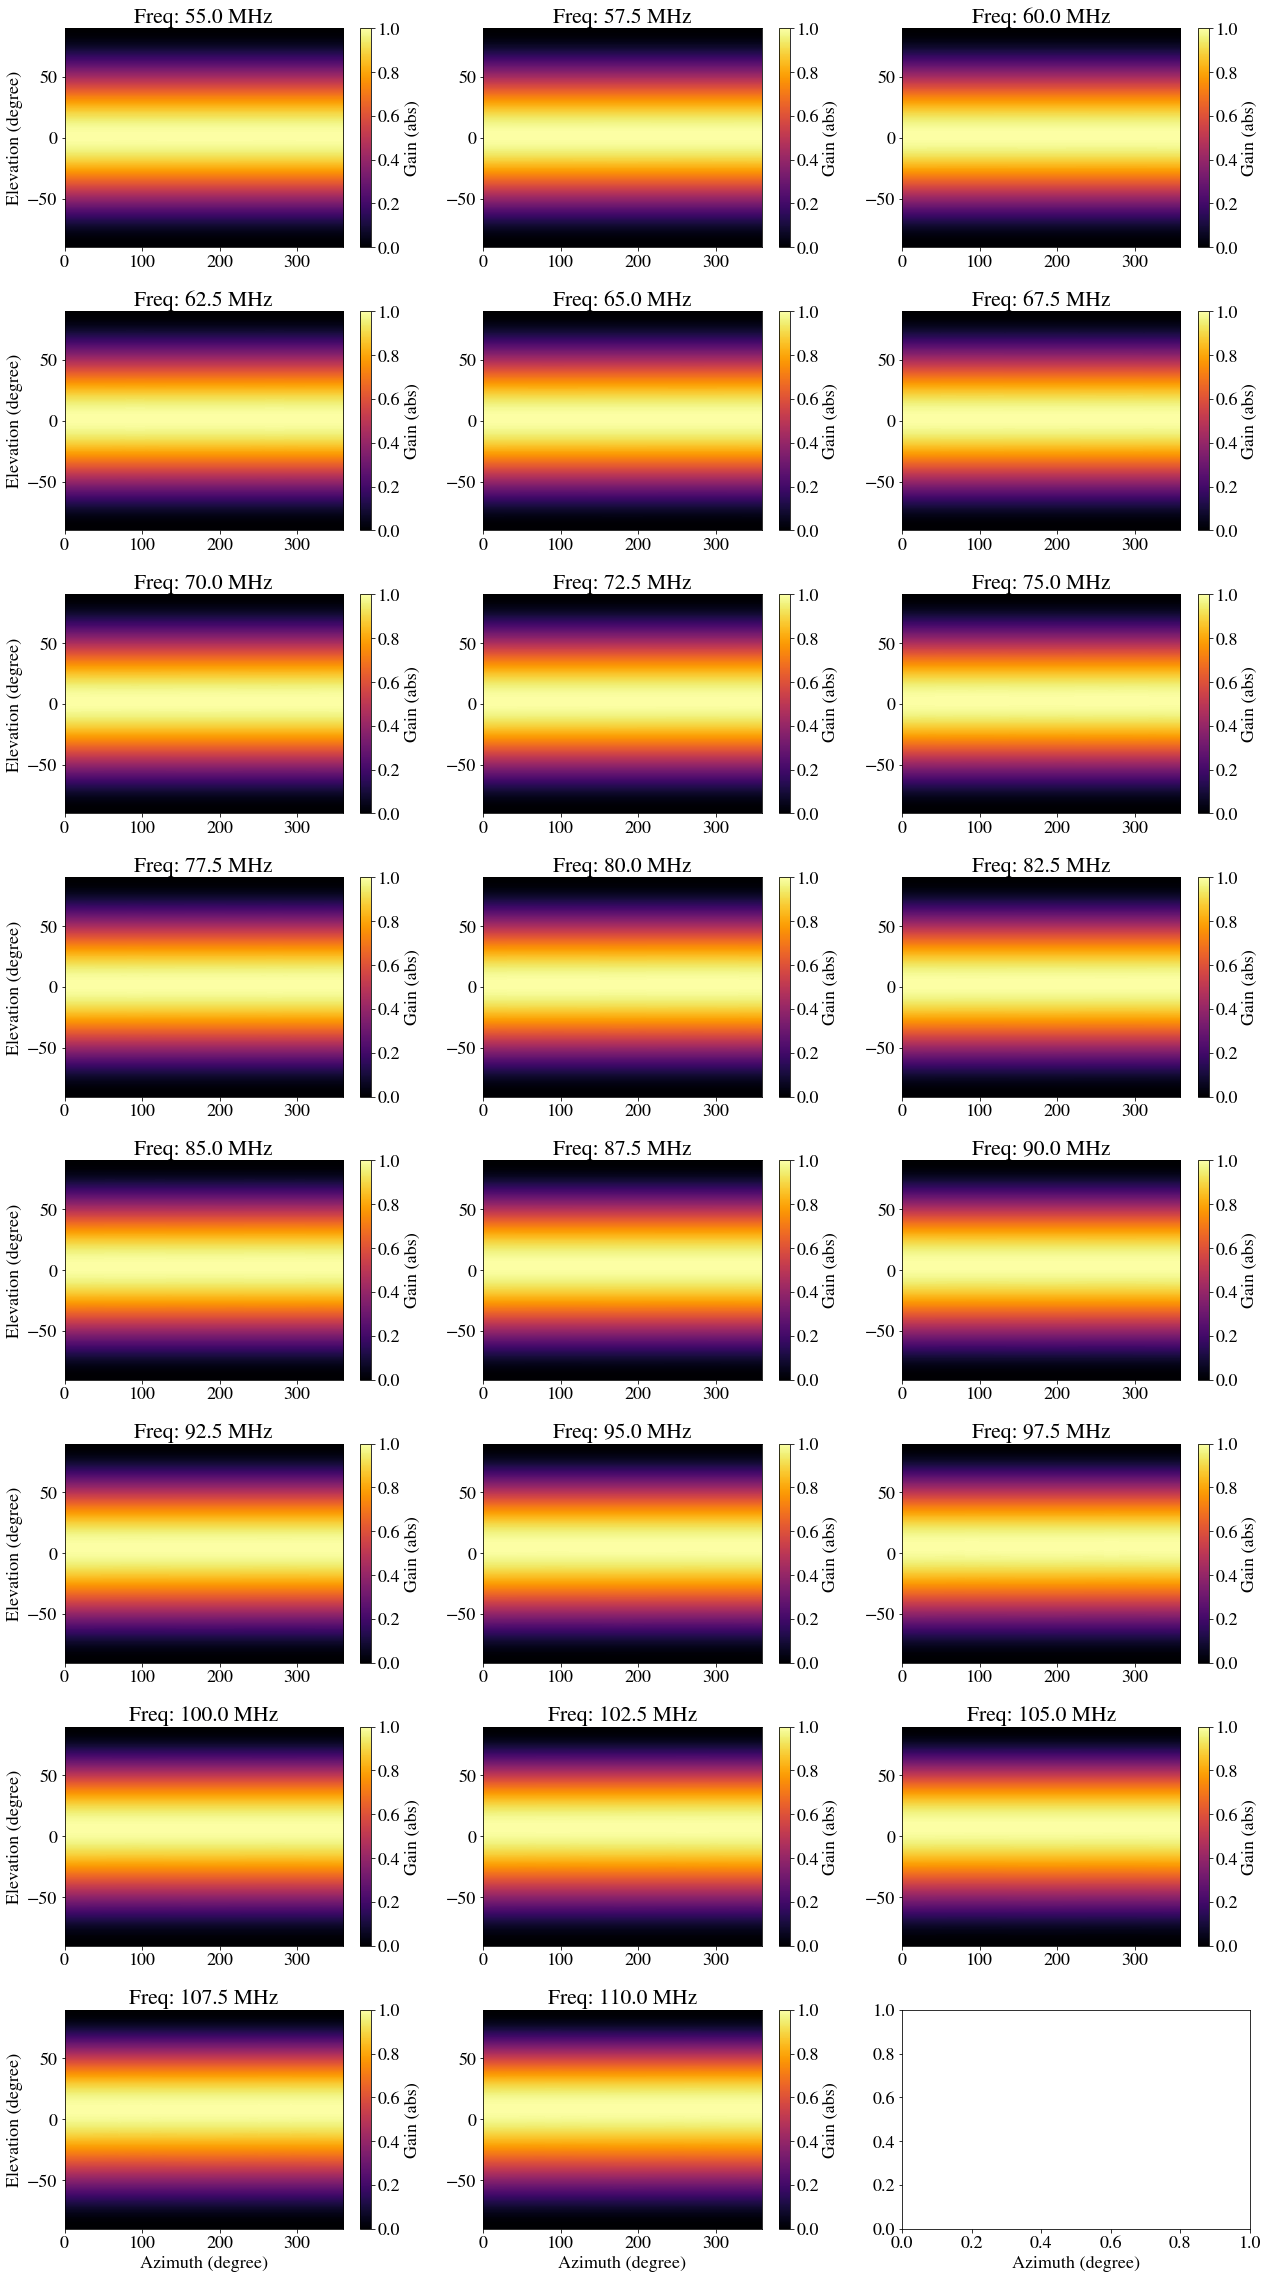

In [131]:
extent = (phi_array[0], phi_array[-1], theta_array[0], theta_array[-1])

nplots = len(freq_array)
ncol   = 3
nrow   = int(np.ceil(nplots/ncol))

fig, _ax = plt.subplots(nrow,ncol,figsize=(6*ncol,4*nrow))
axs      = np.ravel(_ax)

for val, (ax, freq) in enumerate(zip(axs, freq_array)):
    im = ax.imshow(beam_3D[val], aspect='auto', origin='lower', \
                   extent=extent, vmin=0, vmax=1, cmap='inferno')
    fig.colorbar(im, ax=ax, label='Gain (abs)')
    ax.set_title("Freq: {:.1f} MHz".format(freq))

for ax in _ax[:,0]:
    ax.set_ylabel("Elevation (degree)")
for ax in _ax[-1]:
    ax.set_xlabel("Azimuth (degree)")
    
fig.tight_layout()
plt.savefig("beam_plot", dpi=100)
plt.show()

In [132]:
nfreq, ntheta, nphi = beam_3D.shape
ind_phi_0 = np.argmin(np.abs(phi_array))

In [13]:
from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist import angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from mpl_toolkits.axisartist.floating_axes import GridHelperCurveLinear, FloatingSubplot

def fractional_polar_axes(f, thlim=(0, 180), rlim=(0, 1), step=(30, 0.2),
                          thlabel='Elevation angle', rlabel='Normalized response', ticklabels=True):
    """Return polar axes that adhere to desired theta (in deg) and r limits. steps for theta
    and r are really just hints for the locators. Using negative values for rlim causes
    problems for GridHelperCurveLinear for some reason"""
    th0, th1 = thlim # deg
    r0, r1 = rlim
    thstep, rstep = step

    # scale degrees to radians:
    tr_scale = Affine2D().scale(np.pi/180., 1.)
    tr = tr_scale + PolarAxes.PolarTransform()
    theta_grid_locator = angle_helper.LocatorDMS((th1-th0) // thstep)
    r_grid_locator = MaxNLocator((r1-r0) // rstep)
    theta_tick_formatter = angle_helper.FormatterDMS()
    grid_helper = GridHelperCurveLinear(tr,
                                        extremes=(th0, th1, r0, r1),
                                        grid_locator1=theta_grid_locator,
                                        grid_locator2=r_grid_locator,
                                        tick_formatter1=theta_tick_formatter,
                                        tick_formatter2=None)


    a = FloatingSubplot(f, 111, grid_helper=grid_helper)
    f.add_subplot(a)

    # adjust x axis (theta):
    a.axis["bottom"].set_visible(False)
    a.axis["top"].set_axis_direction("bottom") # tick direction
    a.axis["top"].toggle(ticklabels=ticklabels, label=bool(thlabel))
    a.axis["top"].major_ticklabels.set_axis_direction("top")
    a.axis["top"].label.set_axis_direction("top")

    # adjust y axis (r):
    a.axis["left"].set_axis_direction("bottom") # tick direction
    a.axis["right"].set_axis_direction("top") # tick direction
    a.axis["left"].toggle(ticklabels=ticklabels, label=bool(rlabel))

    # add labels:
    a.axis["top"].label.set_text(thlabel)
    a.axis["left"].label.set_text(rlabel)

    # create a parasite axes whose transData is theta, r:
    auxa = a.get_aux_axes(tr)
    # make aux_ax to have a clip path as in a?:
    auxa.patch = a.patch
    # this has a side effect that the patch is drawn twice, and possibly over some other
    # artists. So, we decrease the zorder a bit to prevent this:
    a.patch.zorder = -2

    # add sector lines for both dimensions:
    thticks = grid_helper.grid_info['lon_info'][0]
    rticks = grid_helper.grid_info['lat_info'][0]
    for th in thticks[1:-1]: # all but the first and last
        auxa.plot([th, th], [r0, r1], '--', c='grey', zorder=-1)
    for ri, r in enumerate(rticks):
        # plot first r line as axes border in solid black only if it isn't at r=0
        if ri == 0 and r != 0:
            ls, lw, color = 'solid', 2, 'black'
        else:
            ls, lw, color = 'dashed', 1, 'grey'
        # From http://stackoverflow.com/a/19828753/2020363
        auxa.add_artist(plt.Circle([0, 0], radius=r, ls=ls, lw=lw, color=color, fill=False,
                        transform=auxa.transData._b, zorder=-1))
    return auxa

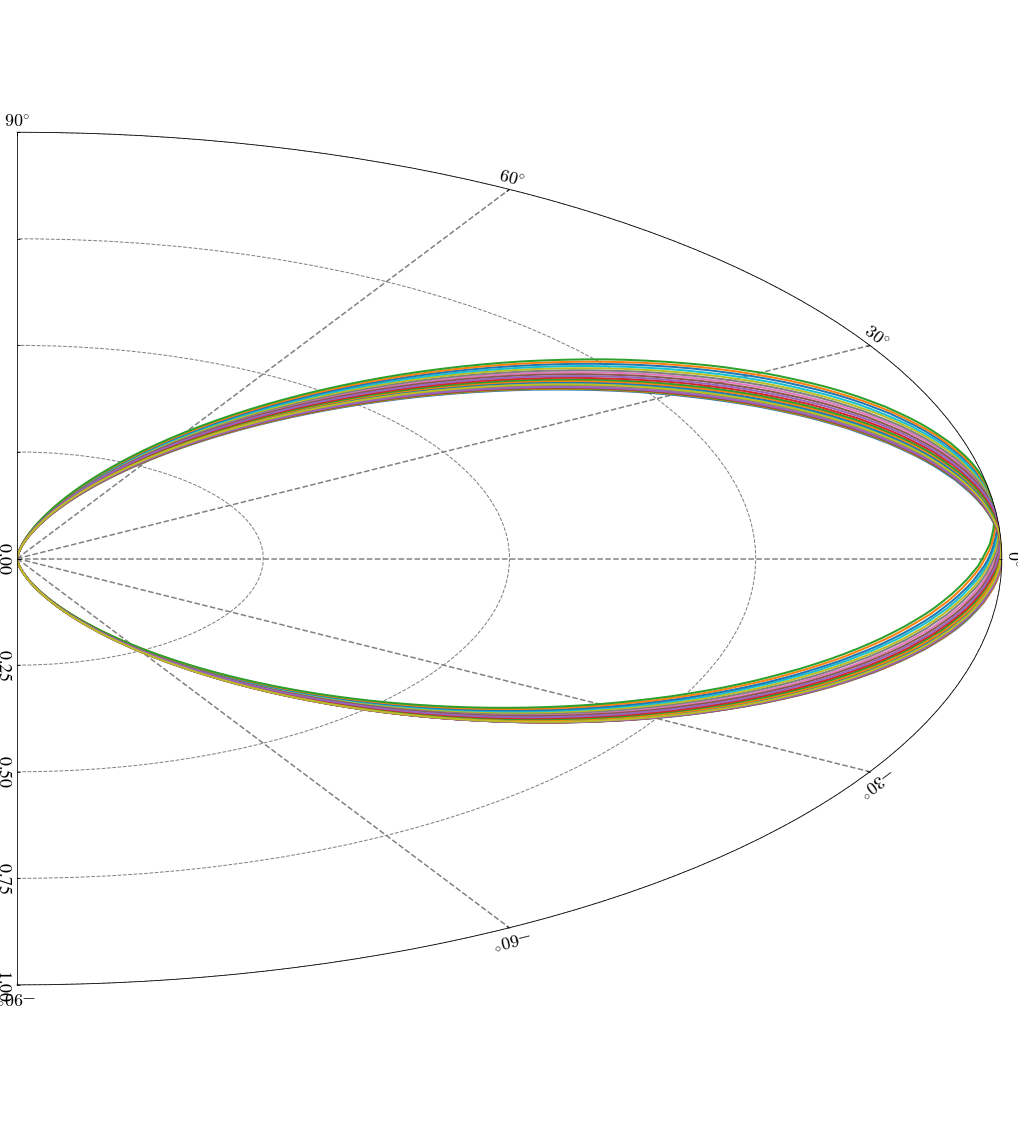

In [49]:
f1     = plt.figure(figsize=(18,16))
a1     = fractional_polar_axes(f1, thlim=(-90,90), rlim=(0,1))
a1.plot(theta_array, beam_3D[:,:,ind_phi_0].T, linewidth=2.0)
plt.tight_layout()
plt.show()

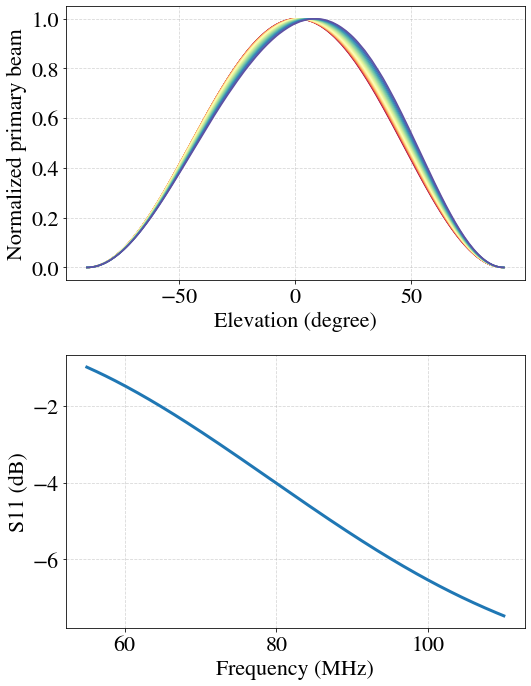

In [133]:
matplotlib.rcParams.update({'font.size': 22})

nrow, ncol = 2, 1
fig, _ax = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

ax = _ax.ravel()

colors = plt.cm.Spectral(np.linspace(0,1,nfreq))

for ii in range(nfreq):
    ax[0].plot(theta_array, beam_3D[ii,:,ind_phi_0], color=colors[ii])
  
   
ax[0].set_xlabel("Elevation (degree)")
ax[0].set_ylabel("Normalized primary beam")
ax[0].grid(ls='--', alpha=0.5)






FMIN, FMAX = 55, 110
ind_freq = np.logical_and(gamma_freq>=FMIN, gamma_freq<=FMAX)

ax[1].plot(gamma_freq[ind_freq], 20*np.log10(gamma_val[ind_freq]), lw=3.0)
ax[1].set_xlabel("Frequency (MHz)")
ax[1].set_ylabel("S11 (dB)")
ax[1].grid(ls='--', alpha=0.5)


fig.tight_layout()


    
plt.savefig("PRATUSH_antenna", dpi=100)
plt.show()

/home/ghoshsonia/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v not in values:


ValueError: array([[0.61960784, 0.00392157, 0.25882353, 1.        ],
       [0.71264898, 0.10711265, 0.28081507, 1.        ],
       [0.8141484 , 0.21968474, 0.30480584, 1.        ],
       [0.87581699, 0.30457516, 0.29411765, 1.        ],
       [0.93302576, 0.39131103, 0.27197232, 1.        ],
       [0.96655133, 0.49742407, 0.29504037, 1.        ],
       [0.98177624, 0.60738178, 0.34579008, 1.        ],
       [0.9928489 , 0.71695502, 0.4094579 , 1.        ],
       [0.99469435, 0.80922722, 0.48696655, 1.        ],
       [0.99638601, 0.88796617, 0.56109189, 1.        ],
       [0.99823145, 0.94517493, 0.65705498, 1.        ],
       [0.99807766, 0.99923106, 0.74602076, 1.        ],
       [0.95578624, 0.98231449, 0.68004614, 1.        ],
       [0.90965013, 0.96386005, 0.60807382, 1.        ],
       [0.82029988, 0.92756632, 0.61268743, 1.        ],
       [0.71141869, 0.88327566, 0.63483276, 1.        ],
       [0.59100346, 0.8355248 , 0.64429066, 1.        ],
       [0.47427912, 0.78985006, 0.64598231, 1.        ],
       [0.36001538, 0.71618608, 0.66551326, 1.        ],
       [0.26405229, 0.60915033, 0.70980392, 1.        ],
       [0.212995  , 0.51141869, 0.73079585, 1.        ],
       [0.29419454, 0.40622837, 0.68096886, 1.        ],
       [0.36862745, 0.30980392, 0.63529412, 1.        ]]) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

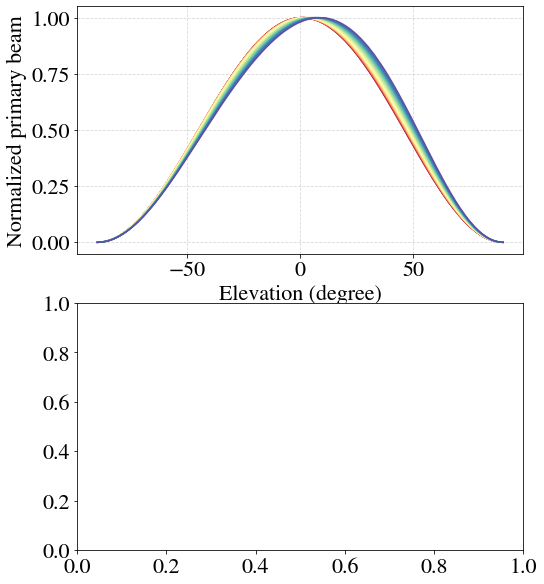

In [209]:
matplotlib.rcParams.update({'font.size': 22})
import matplotlib as mpl
nrow, ncol = 2, 1
fig, _ax = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

ax = _ax.ravel()

colors = plt.cm.Spectral(np.linspace(0,1,nfreq))

for ii in range(nfreq):
    ax[0].plot(theta_array, beam_3D[ii,:,ind_phi_0], color=colors[ii])
   
ax[0].set_xlabel("Elevation (degree)")
ax[0].set_ylabel("Normalized primary beam")
ax[0].grid(ls='--', alpha=0.5)




norm = mpl.colors.Normalize(vmin=0,vmax=2)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])
fig.colorbar(sm, ticks=np.linspace(56,109,nfreq), 
             boundaries=np.arange(-0.05,2.1,.1),ax=ax[0])


#plt.show()



In [178]:
colors[0]

array([0.61960784, 0.00392157, 0.25882353, 1.        ])

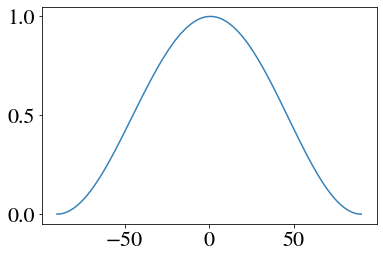

In [210]:
plt.plot(theta_array, beam_3D[0,:,ind_phi_0], color=colors[20])

In [134]:
for val, (ax, freq) in enumerate(zip(axs, freq_array)):
    im = ax.imshow(beam_3D[val], aspect='auto', origin='lower', \
                   extent=extent, vmin=0, vmax=1, cmap='inferno')

## Read files from GMOSS and 21-cm atlas

In [135]:
ll_coordinate, bb_coordinate = np.radians(Read_Two_Column_File(PATH+filename_coord))

T1, nspec1 = Read_pixel_freq(PATH+filename_pix_spec1, RNUMBER_OF_CHANNELS)
T2, nspec2 = Read_pixel_freq(PATH+filename_pix_spec2, QNUMBER_OF_CHANNELS)
T3, nspec3 = Read_pixel_freq(PATH+filename_pix_spec3, PNUMBER_OF_CHANNELS)

freq    = np.zeros(nspec1+nspec2+nspec3)
T_pix   = np.zeros((NHPIX, nspec1+nspec2+nspec3))

for i in range(0, nspec2):
    freq[i]=(float)(QSTART_FREQUENCY/1000.0) +\
            ((float)(QCHANNEL_WIDTH)/1000.0)*(float)(i)
for i in range(nspec2, (nspec1+nspec2)):
    freq[i]=(float)(RSTART_FREQUENCY/1000.0) + ((float)(RCHANNEL_WIDTH)/1000.0)*(float)(i-nspec2)
for i in range(nspec1+nspec2, (nspec1+nspec2+nspec3)):
    freq[i]=(float)(PSTART_FREQUENCY/1000.0)+((float)(PCHANNEL_WIDTH)/1000.0)*(float)(i-(nspec1+nspec2))

for j in range(0, NHPIX):
    T_pix[j][0:nspec2]=T2[j]
    T_pix[j][(nspec2):(nspec1+nspec2)]=T1[j]
    T_pix[j][(nspec1+nspec2):(nspec1+nspec2+nspec3)]=T3[j]
    
freq_org, T_pix_org = copy.deepcopy(freq), copy.deepcopy(T_pix)

#data21   = scipy.io.loadmat(os.path.join(path_ms1, 'atlas/Data_18March_wMFP.mat'))
#data21   = data21['Data2']/1e3 
#fr       = np.loadtxt(os.path.join(path_ms1,'atlas/freq_saras.txt')) #Frequency in MHz
#signal   = interpolate.interp1d(fr, data21)

In [139]:
np.shape(freq)

(216,)

In [140]:
freq

array([0.03955078, 0.04052734, 0.04150391, 0.04248047, 0.04345703,
       0.04443359, 0.04541016, 0.04638672, 0.04736328, 0.04833984,
       0.04931641, 0.05029297, 0.05126953, 0.05224609, 0.05322266,
       0.05419922, 0.05517578, 0.05615234, 0.05712891, 0.05810547,
       0.05908203, 0.06005859, 0.06103516, 0.06201172, 0.06298828,
       0.06396484, 0.06494141, 0.06591797, 0.06689453, 0.06787109,
       0.06884766, 0.06982422, 0.07080078, 0.07177734, 0.07275391,
       0.07373047, 0.07470703, 0.07568359, 0.07666016, 0.07763672,
       0.07861328, 0.07958984, 0.08056641, 0.08154297, 0.08251953,
       0.08349609, 0.08447266, 0.08544922, 0.08642578, 0.08740234,
       0.08837891, 0.08935547, 0.09033203, 0.09130859, 0.09228516,
       0.09326172, 0.09423828, 0.09521484, 0.09619141, 0.09716797,
       0.09814453, 0.09912109, 0.10009766, 0.10107422, 0.10205078,
       0.10302734, 0.10400391, 0.10498047, 0.10595703, 0.10693359,
       0.10791016, 0.10888672, 0.10986328, 0.11083984, 0.11181

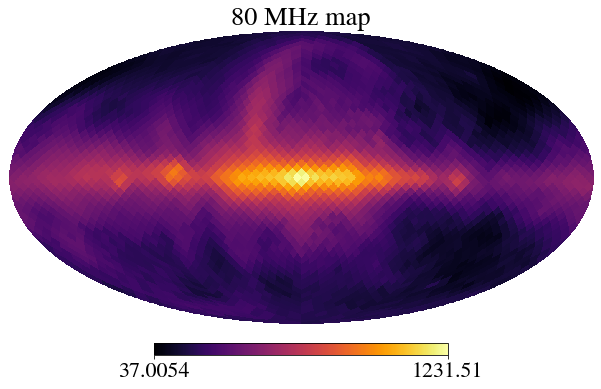

In [141]:
map1 = T_pix_org[:,215]
hp.mollview(map1,title="80 MHz map", norm='log', cmap='inferno', xsize=1400, nest=True)
#np.argmin(np.abs(80-freq_org))

plt.savefig("80_MHz", dpi=200)

## Covolve beam with GMOSS

In [142]:
ifr_low, ifr_hgh = select_freq_1d(freq_org, fmin, fmax)

freq  = freq_org[ifr_low:ifr_hgh]*1e3

T_pix = T_pix_org[:,ifr_low:ifr_hgh]

In [25]:
freq[3]-freq[2]

0.9765625

In [173]:
#dt = TimeDelta(np.arange(0.,24.*3600,10000000), format='sec')
#dt = TimeDelta(np.linspace(0.,24.*3600, 3), format='sec') #Will take ~5 min

dt = TimeDelta(np.linspace(0.,24.*3600, 5), format='sec') #Will take ~5 min

obstimes = Time('2019-4-12 23:00:00') + dt

In [174]:
hanle = EarthLocation(lat=SITE_LATITUDE*u.deg, lon=SITE_LONGITUDE*u.deg, height=4500*u.m)
gc    = SkyCoord(l=ll_coordinate*u.radian, b=bb_coordinate*u.radian,\
        frame='galactic')

#T_bws          = np.zeros((obstimes.shape[0], freq.shape[0]))
#T_bws_monopole = np.zeros((obstimes.shape[0], freq.shape[0]))
#T_monopole = np.zeros((obstimes.shape[0], freq.shape[0]))


#Get RA, DEC 
trans      = gc.transform_to('icrs')
ra, dec    = trans.ra.hour, trans.dec.hour

observing_time = Time(obstimes, scale='utc', location=hanle)
LST            = observing_time.sidereal_time('mean').value

In [188]:
T_bws_monopole_AUS= np.zeros((obstimes.shape[0], freq.shape[0]))
T_monopole_AUS_sin = np.zeros((obstimes.shape[0], freq.shape[0]))

In [146]:
#%store -r beam_pattern
%store -r power_output
%store -r elev_ang

    


In [23]:
nside=16
NPIX = hp.nside2npix(nside) # Storing the number of pixels of the map corresponding to the given NSIDE
arr=np.arange(NPIX)

In [44]:
power_output[1,arr!=686,:]=0

In [115]:
%store -r freq_rfi
freq1=freq_rfi

In [58]:
    
beam_gen_rfi = np.zeros_like(T_pix)
for ifreq, freq_value in enumerate(freq1):
    rogue_phi  = []
    for iangle, (alt_value, az_value) in enumerate(zip(elev_ang[1,686,:], az)):           
        if az_value > phi_array_new.max():
            rogue_phi.append(az_value)
            az_value = 360 - az_value
                
        beam_gen_rfi[iangle,ifreq] = my_interpolating_function([freq_value, alt_value, az_value])

In [69]:
beam_gen_rfi

array([[0.00042694, 0.0004271 , 0.00042731, ..., 0.00040118, 0.00040036,
        0.00039954],
       [0.0004427 , 0.00044287, 0.00044309, ..., 0.00041588, 0.00041502,
        0.0004142 ],
       [0.00051984, 0.00052003, 0.00052028, ..., 0.0004887 , 0.0004877 ,
        0.00048671],
       ...,
       [0.00199687, 0.00199778, 0.00199881, ..., 0.00187905, 0.00187523,
        0.00187161],
       [0.0021264 , 0.00212736, 0.00212844, ..., 0.00200077, 0.00199663,
        0.00199272],
       [0.00210014, 0.00210109, 0.00210216, ..., 0.00197597, 0.00197185,
        0.00196805]])

In [47]:
beam_gen_rfi[]

array([[0.00042694, 0.0004271 , 0.00042731, ..., 0.00040118, 0.00040036,
        0.00039954],
       [0.0004427 , 0.00044287, 0.00044309, ..., 0.00041588, 0.00041502,
        0.0004142 ],
       [0.00051984, 0.00052003, 0.00052028, ..., 0.0004887 , 0.0004877 ,
        0.00048671],
       ...,
       [0.00199687, 0.00199778, 0.00199881, ..., 0.00187905, 0.00187523,
        0.00187161],
       [0.0021264 , 0.00212736, 0.00212844, ..., 0.00200077, 0.00199663,
        0.00199272],
       [0.00210014, 0.00210109, 0.00210216, ..., 0.00197597, 0.00197185,
        0.00196805]])

In [118]:
for val, (time,i) in enumerate(zip(obstimes, tqdm(range(len(obstimes))))):
    
    print("Processing time: {}".format(time))
   
    #Get Alt, Az
    
    trans_local                 = gc.transform_to(AltAz(obstime=time, location=hanle))
    az, alt                     = trans_local.az.degree, trans_local.alt.degree
   
    ind_below_horizon           = alt < 0
       
    ############################
    
    beam_gen = np.zeros_like(T_pix)

    for ifreq, freq_value in enumerate(freq):
        rogue_phi  = []
        for iangle, (alt_value, az_value) in enumerate(zip(alt, az)):
            
            if az_value > phi_array_new.max():
                rogue_phi.append(az_value)
                az_value = 360 - az_value
                
            beam_gen[iangle,ifreq] = my_interpolating_function([freq_value, alt_value, az_value])
    beam_gen[ind_below_horizon,:] = np.nan   
        
    beam_gen_rfi = np.zeros_like(T_pix)
    for ifreq, freq_value in enumerate(freq1):
        rogue_phi  = []
        for iangle, (alt_value, az_value) in enumerate(zip(elev_ang[1,2167,:], az)):           
            if az_value > phi_array_new.max():
                rogue_phi.append(az_value)
                az_value = 360 - az_value
                
            beam_gen_rfi[iangle,ifreq] = my_interpolating_function([freq_value, alt_value, az_value])
            

#     T_bws[val]                    = np.nansum(T_pix * beam_gen, axis=0)/np.nansum(beam_gen, axis=0)
    
    #############################
    
    #beam_gen_monopole                    = beam_monopole(alt, az)
    #beam_rfi=beam_monopole(elev_ang[1,686,:],az)
    #beam_gen_monopole[ind_below_horizon] = np.nan 
   # T_bws_monopole[val]                  = np.nansum(T_pix * beam_gen_monopole[:,None],axis=0)\
                                         #  /np.nansum(beam_gen_monopole)
    #T_bws_monopole[val]                  = np.nansum(T_pix * beam_gen_monopole[:,None],axis=0)\
                                             #  /np.nansum(beam_gen_monopole)
   # T_monopole[val]                  = np.nansum(T_pix * beam_gen_monopole[:,None]+ power_output[1,:,:],axis=0)\
                                       #/np.nansum(beam_gen_monopole)
    
    #T_bws_monopole_HAN[val]                  = np.nansum(T_pix * beam_gen_monopole[:,None],axis=0)\
                                               #/np.nansum(beam_gen_monopole)
    #T_monopole_HAN[val]                      = (np.nansum(T_pix * beam_gen_monopole[:,None],axis=0)/np.nansum(beam_gen_monopole))\
                                                #+(power_output[1,686,:]/np.nansum(beam_rfi)) #+ power_output[0,:,:],axis=0)\
                                         
    #T_monopole_HAN_new[val]                      = (np.nansum(T_pix * beam_gen,axis=0)/np.nansum(beam_gen,axis=0))\
                                                #+(np.nansum(power_output[1,686,:]*beam_gen_rfi,axis=0)/np.nansum(beam_gen_rfi,axis=0)) #+ power_output[0,:,:],axis=0)\
                                         
    T_monopole_AUS_new[val]                      = (np.nansum(T_pix * beam_gen + power_output[1,2167,:]*beam_gen_rfi,axis=0)/np.nansum(beam_gen+beam_gen_rfi,axis=0))
                                                                                    
    #############################

  0%|          | 0/5 [00:00<?, ?it/s]

Processing time: 2019-04-12 23:00:00.000
Processing time: 2019-04-13 05:00:00.000
Processing time: 2019-04-13 11:00:00.000
Processing time: 2019-04-13 17:00:00.000
Processing time: 2019-04-13 23:00:00.000


In [189]:
for val, (time,i) in enumerate(zip(obstimes, tqdm(range(len(obstimes))))):
    
    print("Processing time: {}".format(time))
   
    #Get Alt, Az
    
    trans_local                 = gc.transform_to(AltAz(obstime=time, location=hanle))
    az, alt                     = trans_local.az.degree, trans_local.alt.degree
   
    ind_below_horizon           = alt < 0
    
    beam_gen_monopole                    = beam_monopole(alt, az)
    beam_rfi=beam_monopole(elev_ang[0,2167,:],az)
    beam_gen_monopole[ind_below_horizon] = np.nan 
   
    T_monopole_AUS_sin[val]          = (np.nansum(T_pix * beam_gen_monopole[:,None] + power_output[0,2167,:]*beam_rfi[:,None],axis=0)/np.nansum(beam_gen_monopole+beam_rfi,axis=0))
                                                                                    

    

  0%|          | 0/5 [00:00<?, ?it/s]

Processing time: 2019-04-12 23:00:00.000
Processing time: 2019-04-13 05:00:00.000
Processing time: 2019-04-13 11:00:00.000
Processing time: 2019-04-13 17:00:00.000
Processing time: 2019-04-13 23:00:00.000


In [162]:
beam_gen_monopole

array([0.58404285, 0.63964982, 0.60634151, ..., 0.86585731, 0.90979264,
       0.90646603])

In [165]:
beam_rfi

array([0.0016831 , 0.00160343, 0.00169154, ..., 0.00050146, 0.00055243,
       0.00059963])

In [93]:
diff=T_monopole_HAN_new[4]-T_monopole_HAN_new[0]
diff

array([ 40.72718209, -24.67266016, -23.72229698, -22.82208536,
       -21.96938656, -21.16801926, -20.40707137, -19.68006957,
       -18.98505492, -18.32380125, -17.6971766 , -17.10026415,
       -16.5315792 , -15.98971383, -15.47233803, -14.97490373,
       -14.4987937 , -14.04429803, -13.61162584, -13.19729686,
       -12.79715622, -11.73861932, -12.04298761,  -7.6788595 ,
        -5.14119283,  13.60069698,  -1.65667309,   1.30893499,
       -10.10749377,  -6.80226376,  -3.7271889 ,  -9.29995723,
        73.50600033, 331.65017011, 193.15101258, 267.37414387,
       242.70469292, 266.03222358, 264.47546584, 272.71013882,
       208.25876728, 233.76955815, 213.80465531, 190.63883035,
       207.37722403, 256.29429052, 231.48295769, 206.049055  ,
       201.51514014, 202.43725411, 142.0013361 , 164.27812917,
       152.7375093 ,  73.4142828 ,  -5.2083962 ])

In [53]:
T_pix * beam_gen

array([[3870.59082227, 3724.60599328, 3585.90054503, ..., 1043.02899904,
        1027.35617242, 1012.33715659],
       [2319.32650624, 2231.77278735, 2148.28188242, ...,  621.47810183,
         612.12675199,  603.14542809],
       [3398.19412271, 3268.15224996, 3144.55856395, ...,  892.29530362,
         878.55089579,  865.35837046],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])

In [61]:
np.shape(power_output[1,:,:]*beam_gen_rfi)

(3072, 55)

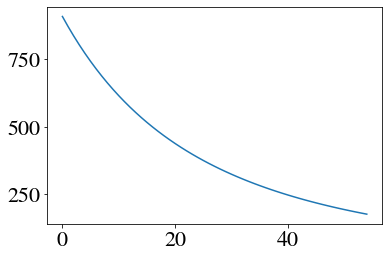

In [68]:
diff2=T_bws_monopole_aus[250]-T_bws_monopole[250]
plt.plot(diff2)
plt.show()

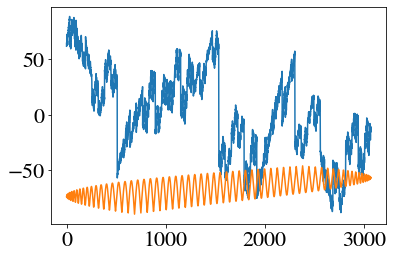

In [218]:
plt.plot(alt)
plt.plot(elev_ang[0,686,:])

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITHOUT RFI ')

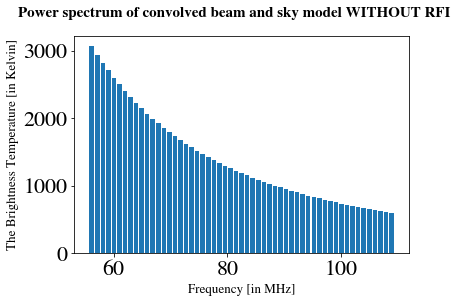

In [156]:

plt.bar(freq,T_bws_monopole_HAN[250]) 
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITHOUT RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITHOUT RFI ')

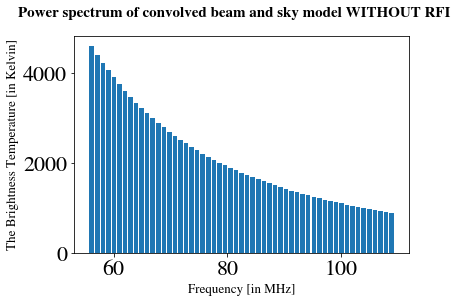

In [70]:
plt.bar(freq,T_bws_monopole_aus[250]) 
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITHOUT RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

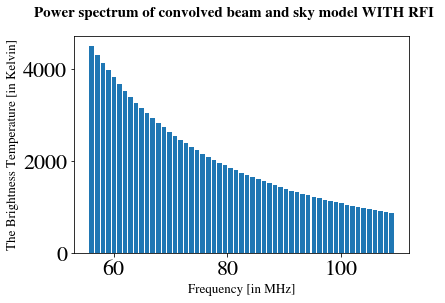

In [149]:
plt.bar(freq,T_monopole_HAN[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

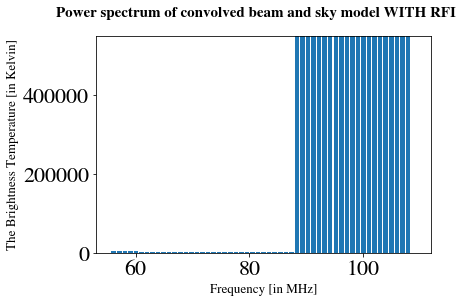

In [134]:
plt.bar(freq,T_monopole_AUS[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

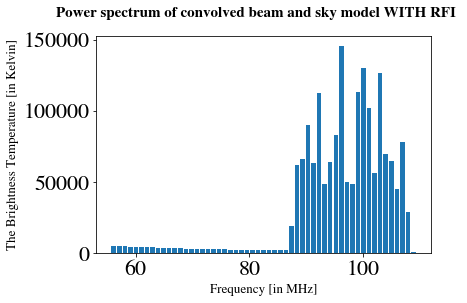

In [119]:
plt.bar(freq,T_monopole_GER[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 20000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

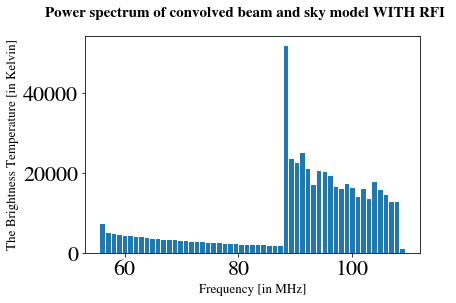

In [121]:
plt.bar(freq,T_monopole_GER[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 20000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

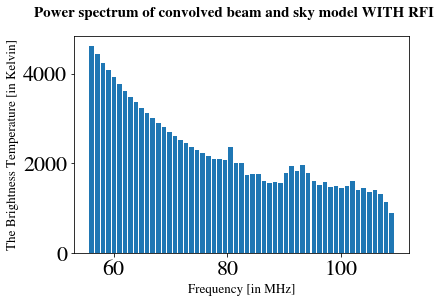

In [136]:
plt.bar(freq,T_monopole_AUS[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

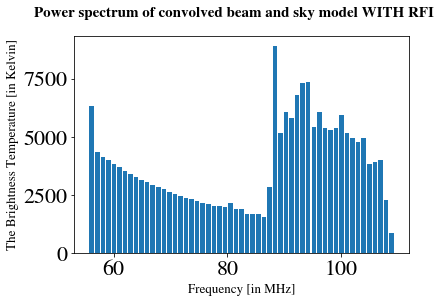

In [152]:
plt.bar(freq,T_monopole_HAN[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

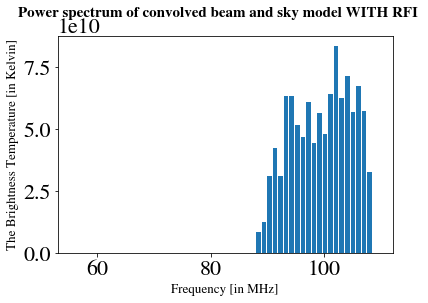

In [117]:
#PRATUSH_AUS_400

plt.bar(freq,T_monopole_AUS_new[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

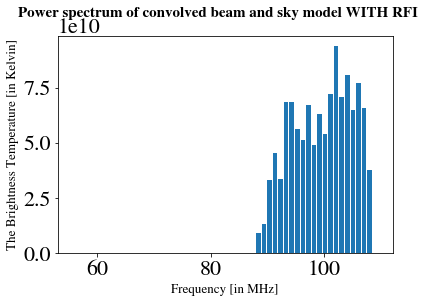

In [171]:
#mono_AUS_400

plt.bar(freq,T_monopole_AUS[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

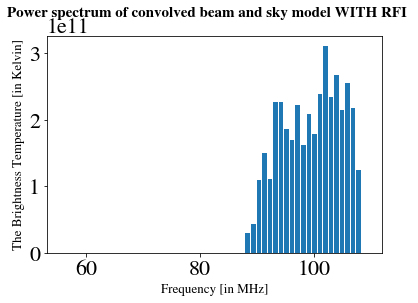

In [190]:
plt.bar(freq,T_monopole_AUS_sin[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

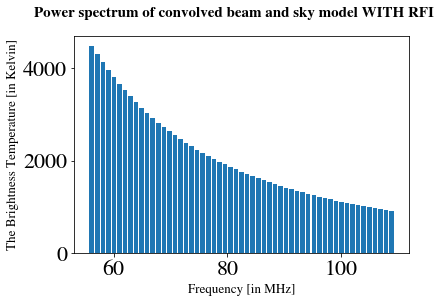

In [95]:
#PRATUSH_HANLE_400

plt.bar(freq,T_monopole_HAN_new[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

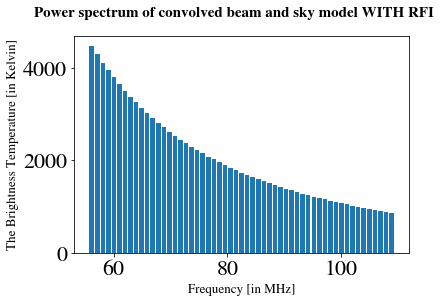

In [182]:
#MONO_HAN_400
plt.bar(freq,T_monopole_HAN[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

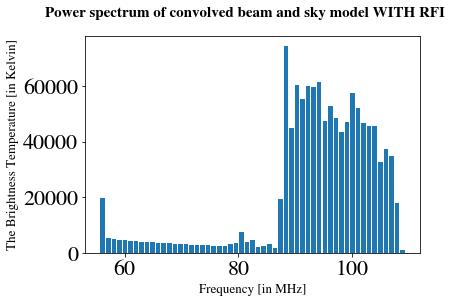

In [87]:
#PRATUSH_HANLE_36000

plt.bar(freq,T_monopole_HAN_new[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

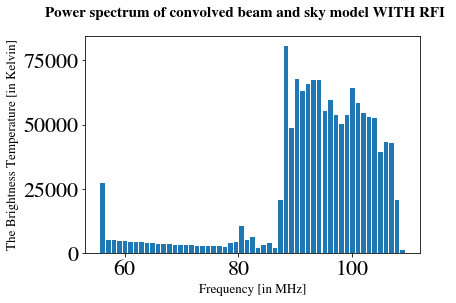

In [180]:
#MONO_HAN_36000
plt.bar(freq,T_monopole_HAN[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

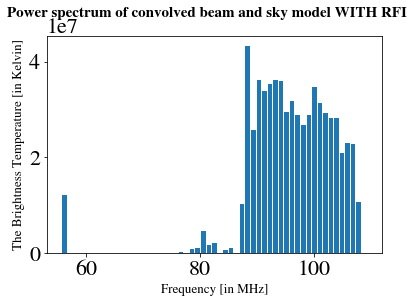

In [187]:
plt.bar(freq,T_monopole_HAN_sin[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

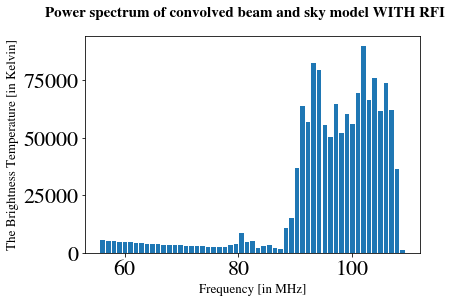

In [121]:
#PRATUSH_AUS_36000

plt.bar(freq,T_monopole_AUS_new[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

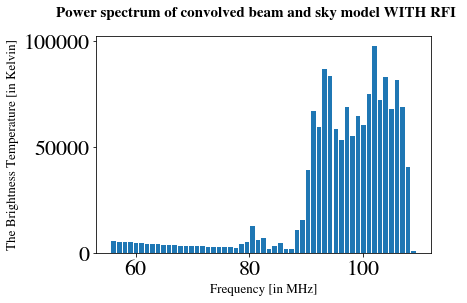

In [159]:
#mono_AUS_36000

plt.bar(freq,T_monopole_AUS_new[0])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

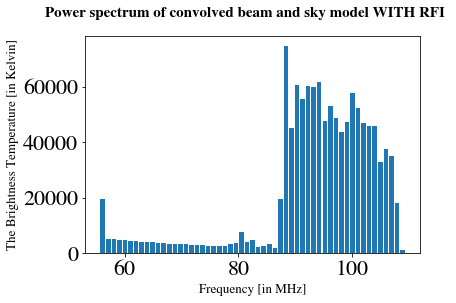

In [90]:
#PRATUSH_HANLE_36000
plt.bar(freq,T_monopole_HAN_new[4])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

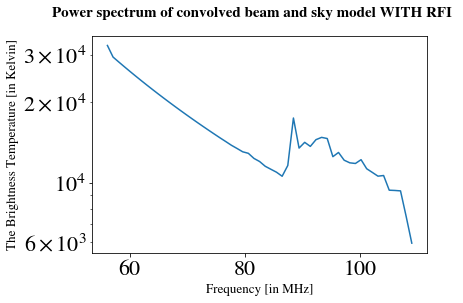

In [174]:
plt.yscale("log")
plt.plot(freq,T_monopole_HAN[250])
#plt.bar(freq,T_monopole_GER[0]-T_bws_monopole_GER[0]) 
#plt.ylim(0, 550000)

plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

## Modulate the spectra with return loss and save data products

In [21]:
gamma_inter = gamma_func(freq)
te          = 1-gamma_inter**2
T_bws_te    = T_bws * te[None,:]
T_te        = T_bws_monopole * te[None,:]

In [21]:
fname = 'monopole'
f = h5py.File(os.path.join('/home/pratush/Documents/PRATUSH', (fname+'.h5')), 'w')

grp = f.create_group('index_map')
grp.create_dataset('frequency', data=freq)
grp.create_dataset('LST', data=LST)

f.create_dataset('T_A', data = T_bws_monopole)
f.close()

In [22]:
f = h5py.File('trial_bws.h5', 'w')

grp = f.create_group('index_map')
grp.create_dataset('frequency', data=freq)
grp.create_dataset('LST', data=LST)

grp2 = f.create_group('ancillary_prod')
grp2.create_dataset('beam', data=beam_3D)
grp2.create_dataset('ref_eff', data=te)

f.create_dataset('BWS',             data = T_bws)
f.create_dataset('BWS_RE',          data = T_bws_te)
f.create_dataset('monopole_BWS',    data = T_bws_monopole)
f.create_dataset('monopole_BWS_RE', data = T_te)

f.close()

In [ ]:
avg_spectra          = np.mean(T_bws, axis=0)
avg_spectra_te       = np.mean(T_bws_te, axis=0)
avg_spectra_te_only  = np.mean(T_te, axis=0)
avg_spectra_monopole = np.mean(T_bws_monopole, axis=0)
T21                  = signal(freq)[100] #One of the vanilla models

## MS fitting

In [ ]:
param_noj = {'domain':domain, 'xmin':LOWF, 'xmax':HGHF, 'rescale':True,\
         'norder':order, 'error':np.ones(len(avg_spectra)), 'additive':False, 'op_file':False, 'op_name':False,\
         'niter':1, 'smooth':False, 'basin_iter_loops':10, 'xtol':1e-10, 'ftol':1e-10,\
         'temp':1e-5, 'stepsize':1e-5}

pe_on_signal_wo_signal, xe_on_signal_wo_signal, imine_on_wo_signal, \
imaxe_on_wo_signal, fite_on_signal_wo_signal, rese_on_signal_wo_signal, ee_on_signal_wo_signal \
=  ms_fit(freq, avg_spectra_te_only, **param_noj)

p_signal_wo_signal, x_signal_wo_signal, imin_wo_signal, \
imax_wo_signal, fit_signal_wo_signal, res_signal_wo_signal, e_signal_wo_signal \
=  ms_fit(freq, avg_spectra, **param_noj)

pe_signal_wo_signal, xe_signal_wo_signal, imine_wo_signal, \
imaxe_wo_signal, fite_signal_wo_signal, rese_signal_wo_signal, ee_signal_wo_signal \
=  ms_fit(freq, avg_spectra_te, **param_noj)

p1_signal_wo_signal, x1_signal_wo_signal, imin1_wo_signal, \
imax1_wo_signal, fit1_signal_wo_signal, res1_signal_wo_signal, e1_signal_wo_signal \
=  ms_fit(freq, avg_spectra_monopole, **param_noj)

p1_signal_wi_signal, x1_signal_wi_signal, imin1_wi_signal, \
imax1_wi_signal, fit1_signal_wi_signal, res1_signal_wi_signal, e1_signal_wi_signal \
=  ms_fit(freq, avg_spectra_monopole + T21, **param_noj)

## Visualize data and fitting results

In [ ]:
res = T_bws - T_bws_monopole

fig, _ax = plt.subplots(2,3,figsize=(6*3,4*2))

ax = _ax.ravel()

im = ax[0].imshow(np.log10(T_bws), aspect='auto', \
           cmap='inferno', origin='lower', vmin=2.5, vmax=4)
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(np.log10(T_bws_monopole), aspect='auto', \
           cmap='inferno', origin='lower', vmin=2.5, vmax=4)
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(T_bws_monopole - T_bws, aspect='auto', \
           cmap='inferno', origin='lower', vmin=-30, vmax=30)
fig.colorbar(im, ax=ax[2])

ax[3].plot(freq, T_bws.T, alpha=0.5, c='k')
ax[3].plot(freq,np.mean(T_bws, axis=0), c='k', ls='--')
ax[3].set_ylim([500,6500])

ax[4].plot(freq, T_bws_monopole.T, alpha=0.5, c='k')
ax[4].plot(freq,np.mean(T_bws_monopole, axis=0), c='k', ls='--')
ax[4].set_ylim([500,6500])

ax[5].plot(freq, (res - np.mean(res, axis=1)[:,None]).T, alpha=0.5, c='k')
ax[5].set_ylim([-10,10])

plt.show()

In [ ]:
res_spec = avg_spectra - avg_spectra_monopole

fig, _ax = plt.subplots(3,2,figsize=(6*2,4*3))

ax = _ax.ravel()

ax[0].plot(freq, avg_spectra, c='r')
ax[0].plot(freq, avg_spectra_monopole, c='k')

ax[1].plot(freq, avg_spectra_te, c='k')
ax[1].plot(freq, avg_spectra_te_only, c='k')

ax[2].plot(freq, res_signal_wo_signal,  label='with real beam', c='r')
ax[2].plot(freq, res1_signal_wo_signal, label='with monopole beam',  c='k')
ax[2].legend()
ax[2].set_ylim([-0.2,0.2])

ax[3].plot(freq, rese_signal_wo_signal, label='with real beam * te',  c='r')
ax[3].plot(freq, rese_on_signal_wo_signal, label='with te',  c='k')
ax[3].legend()
ax[3].set_ylim([-0.2,0.2])
ax[3].set_title("RMS systematics: {:.1f} mK".format(1e3*np.std(rese_on_signal_wo_signal)), color='k')

ax[4].plot(freq, rese_signal_wo_signal/te, label='with real beam * te (corrected)',  c='r')
ax[4].plot(freq, rese_on_signal_wo_signal/te, label='with te (corrected)',  c='k')
ax[4].legend()
ax[4].set_ylim([-0.2,0.2])
ax[4].set_title("RMS systematics: {:.1f} mK".format(1e3*np.std(rese_on_signal_wo_signal/te)), color='k')

ax[5].plot(freq, T21, c='red')
ax[5].set_ylim([-0.2,0.05])
ax[5].xaxis.label.set_color('red')
ax[5].tick_params(axis='y', colors='red')

ax6 = ax[5].twinx()
ax6.plot(freq, res1_signal_wi_signal - res1_signal_wo_signal, label='processed signal',  c='dodgerblue')
ax6.xaxis.label.set_color('dodgerblue')
ax6.tick_params(axis='y', colors='dodgerblue')
ax6.set_title("RMS signal: {:.1f} mK".format(1e3*np.std(res1_signal_wi_signal - res1_signal_wo_signal)), \
              color='dodgerblue')
ax6.set_ylim([-0.02,0.02])
ax6.legend()


for axs in ax:
    axs.grid(ls='--', c='k', alpha=0.2)
    
for axs in ax[:4]:    
    axs.tick_params(labelbottom=False) 
for axs in ax[4:]:    
    axs.set_xlabel("Frequency (MHz)", c='k')
for axs in _ax[:,0]:    
    axs.set_ylabel(r"$T_b$ (K)", c='k')

fig.tight_layout()
plt.show()